In [1]:
import os
os.chdir("..")

Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor

In [3]:
import numpy as np

def get_error_stats(sim, obs, pcol="exc_prb", ycol="precip_avg_mm", to_inches=True):
    f = 25.4 if to_inches else 1.0
    cx = (1 / sim[pcol].to_numpy()).astype(float)
    cy = (sim[ycol].to_numpy() / f).astype(float)
    mx = (1 / obs[pcol].to_numpy()).astype(float)
    my = (obs[ycol].to_numpy() / f).astype(float)

    # clean & sort
    okc, okm = np.isfinite(cx*cy), np.isfinite(mx*my)
    cx, cy = cx[okc], cy[okc]; mx, my = mx[okm], my[okm]
    i, j = np.argsort(cx), np.argsort(mx)
    cx, cy, mx, my = cx[i], cy[i], mx[j], my[j]

    # integer grid 1..floor(max mx)
    xmax = float(mx.max())
    grid = np.arange(1, int(np.floor(xmax)) + 1, dtype=float)

    cyg = np.interp(grid, cx, cy)
    myg = np.interp(grid, mx, my)
    rmse = float(np.sqrt(np.mean((cyg - myg) ** 2)))

    # diff at exact max of monte
    diff_at_max = float(np.interp(xmax, cx, cy) - np.interp(xmax, mx, my))
    return {"rmse": rmse, "diff_at_max": diff_at_max}

Preprocess data

In [ ]:
trinity = Preprocessor(config_path = "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/config.json", 
                       output_folder = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity")
trinity.run()

In [4]:
trinity = Preprocessor.load(config_path = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity/config.json")

Full Monte Uniform Samples

In [6]:
sampler = ImportanceSampler(
    distribution="uniform",
    params = {},
    num_simulations=1_000_000,
    num_rep=1,
)

trinity_fullmonte_samples = sampler.sample(trinity.domain_gdf, trinity.watershed_gdf)

In [7]:
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_fullmonte_depths = processor.shift_and_extract_precip(
    df_storms=trinity_fullmonte_samples,
    n_jobs=-1,    
    seed=42   
)

In [8]:
#Save
trinity_fullmonte_depths.to_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity/trinity_fullmonte_depths.pq")

In [5]:
#Read
trinity_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity/trinity_fullmonte_depths.pq")

Importance Sampling - Truncated Normals

In [6]:
#Sample
params = {
    "mu_x": trinity.watershed_stats["x"],  
    "mu_y": trinity.watershed_stats["y"],      
    "sd_x": trinity.watershed_stats["range_x"],
    "sd_y": trinity.watershed_stats["range_y"]*0.5,                            
}

sampler = ImportanceSampler(
    distribution="truncated_gaussian",
    params=params,
    num_simulations=350_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(trinity.domain_gdf)

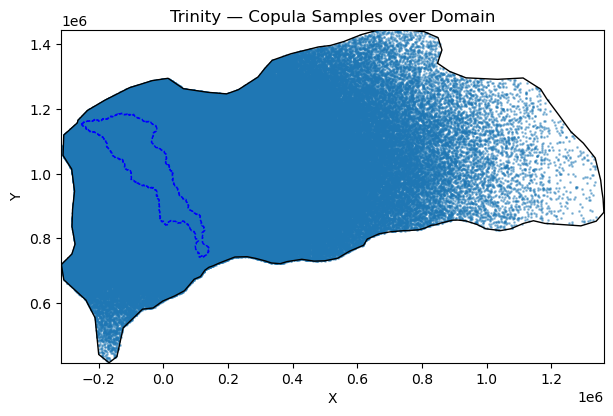

In [9]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Copula Samples over Domain")
plt.show()

In [10]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_gaussian_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

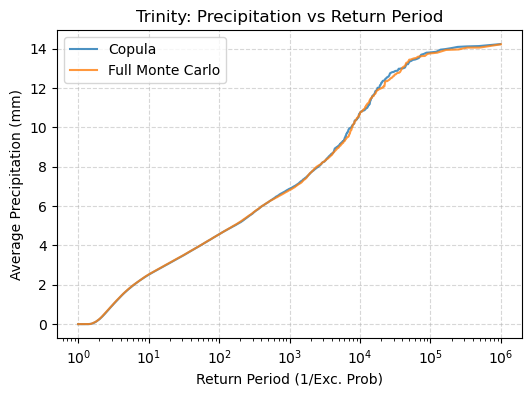

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/trinity_gaussian_depths["exc_prb"], trinity_gaussian_depths["precip_avg_mm"]/25.4, 
         label="Copula", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("Return Period (1/Exc. Prob)")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity: Precipitation vs Return Period")
plt.show()

In [12]:
get_error_stats(trinity_gaussian_depths,trinity_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.07358964184733646, 'diff_at_max': 0.009600114041223407}

Importance Sampling - Gaussian Copula

In [27]:
#Sample
params = {
    "mu_x": trinity.watershed_stats["x"],  
    "mu_y": trinity.watershed_stats["y"],      
    "sd_x": trinity.watershed_stats["range_x"],
    "sd_y": trinity.watershed_stats["range_y"]*0.5, 
    "rho": -0.2,                                
}

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=300_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(trinity.domain_gdf)

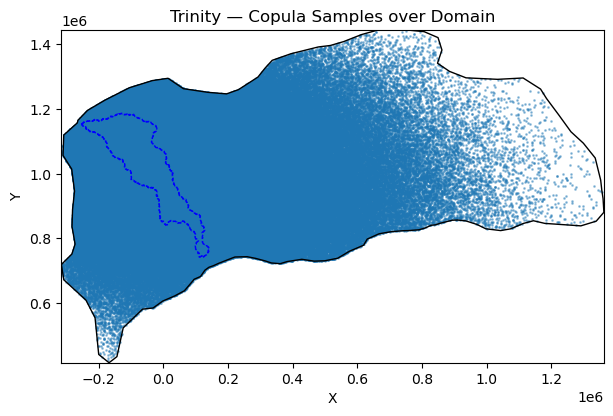

In [28]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Copula Samples over Domain")
plt.show()


In [29]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_copula_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/trinity_copula_depths["exc_prb"], trinity_copula_depths["precip_avg_mm"]/25.4, 
         label="Copula", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity: Precipitation vs Return Period")
plt.show()

NameError: name 'trinity_copula_depths' is not defined

<Figure size 600x400 with 0 Axes>

In [31]:
get_error_stats(trinity_copula_depths,trinity_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.12812811981476055, 'diff_at_max': 0.02024639980838927}

Mixture of two normals

In [67]:
#Sample
params = {
    "mu_x_narrow": trinity.watershed_stats["x"],  
    "mu_y_narrow": trinity.watershed_stats["y"],
    "mu_x_wide": trinity.domain_stats["x"],  
    "mu_y_wide": trinity.domain_stats["y"],
    "sd_x_narrow": trinity.watershed_stats["range_x"]*0.3,
    "sd_y_narrow": trinity.watershed_stats["range_y"]*0.3,
    "sd_x_wide": trinity.domain_stats["range_x"],
    "sd_y_wide": trinity.domain_stats["range_y"],
    "mix": 0.8,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=100_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(trinity.domain_gdf)

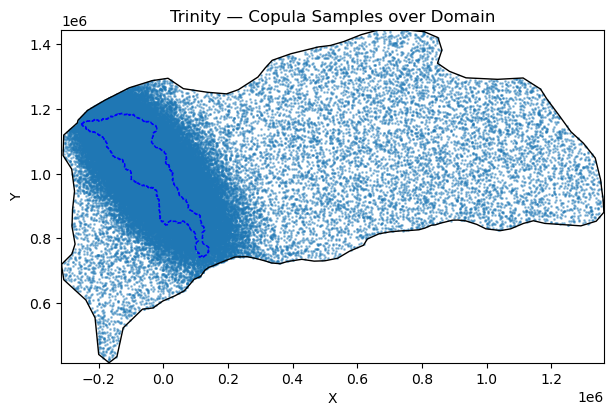

In [68]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Copula Samples over Domain")
plt.show()

In [69]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_mixture_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

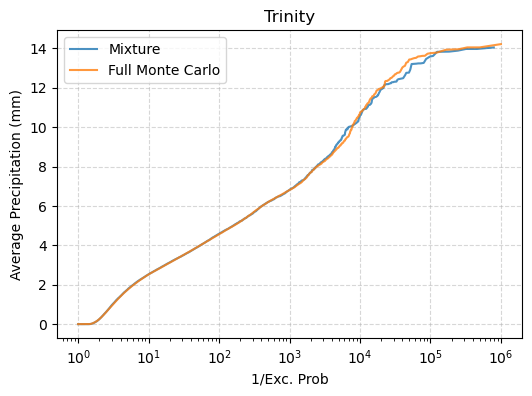

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/trinity_mixture_depths["exc_prb"], trinity_mixture_depths["precip_avg_mm"]/25.4, 
         label="Mixture", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity")
plt.show()

In [71]:
get_error_stats(trinity_mixture_depths,trinity_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.1374263083646515, 'diff_at_max': -0.16899500831493874}